Teaching assistant:

thomas.langrognet@mines-paristech.fr

# Load the dependencies



In [ ]:
import os
import json
from datetime import datetime
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras import backend as K
import imageio
import numpy as np
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data

Create a directory named *data* in your google drive. This directory will be the workspace of the TP. Once, created, copy/paste the dataset folder *tissue* in *data*. Do not modify the folder *tissue*. 


Set the correct path in the cell below. Then run this cell set the script at the *data* level.

In [ ]:
%cd 'gdrive/MyDrive/data'

/content/gdrive/MyDrive/data


# DataGenerator fetching the data

Implement the functions in charge of selecting patches of images within the customised keras DataGenerator class.  
The function *get_random_patch_coord* randomly selects the coordinates of an image's patch. A *patch_coord* points to the lower left corner of the corresponding patch. Thus the coordinates [a,b] gives for a patch of size [c, d] the image's patch *image*[a:a+c,b:b+d].  
The function *choose_patch_coord* calls *get_random_patch_coord* and should return the coordinates of a patch with at most 70% of background labels (pixel value of 0 in label). If it cannot be achieved after 10 tryouts, the function should return the coordinates of the patch with the lowest background labels found.  

In [52]:
class DataGeneratorTissue(keras.utils.Sequence):
    
    def __init__(self, path, prefix, batch_size, 
                 patch_size, nb_channels_in=3, nb_channels_out=1,
                 geometric_augmentations=[], augmentation_ratio=None):
        
        self.path = path
        self.prefix = prefix
        self.get_data_dict()
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.nb_channels_in = nb_channels_in
        self.nb_channels_out = nb_channels_out
        self.geometric_augmentations = []
        self.augmentation_ratio = augmentation_ratio
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, batch_idx):
        batch_data_idxs = self.data_idxs[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
        x, y = self.fetch_data(batch_data_idxs)
        return x, y

    def on_epoch_end(self):
        self.data_idxs = np.arange(len(self.data))
        np.random.shuffle(self.data_idxs)
    
    def get_data_dict(self):
        self.data = {}
        for data_idx, image_name in enumerate(os.listdir(os.path.join(*[self.path, self.prefix, "jpg"]))):
            self.data[data_idx] = image_name
    
    def get_random_patch_coord(self, image_size):
      # we a tuple of random coordinates (x,y)
      # (x,y) belong to [0, image_size0 - patch_size0; 0, image_size1 - patch_size1]
      random_x = np.random.randint(low = 0, high=image_size[0] - self.patch_size[0])
      random_y = np.random.randint(low = 0, high=image_size[1] - self.patch_size[1])
      return (random_x, random_y)
    
    def choose_patch_coord(self, image_shape, label):
        # HINTS
        patch_coord_found = False
        threshold = 70
        itr = 0
        best_patch_coord = None
        lowest_bg_per = np.inf
        
        while (patch_coord_found == False) and (itr < 10):
            patch_coord = self.get_random_patch_coord(image_shape)
            # print("Coords:", patch_coord)
            positives = np.count_nonzero(label[patch_coord[0] : patch_coord[0] + self.patch_size[0], patch_coord[0] : patch_coord[1] + self.patch_size[1]])
            percent_label_non_0 = positives / (patch_size[0] * patch_size[1])
            # print("%non0: ", percent_label_non_0)

            percent_label_0 = 1 - percent_label_non_0
            # print("%0:", percent_label_0)

            if(percent_label_0 <= threshold / 100):
              # print("found good")
              # we have less than 70% of background
              return patch_coord
            
            
            # we do not have less than 70% of background
            # let's check the result
            if percent_label_0 < lowest_bg_per:
              # the new one is closest to 70% than the previous one
              lowest_bg_per = percent_label_0
              best_patch_coord = patch_coord
            
            itr+=1
          
        # print("did not: ", lowest_bg_per)

        return best_patch_coord
        
    def fetch_data(self, batch_data_idxs):
        x = np.empty([self.batch_size, *self.patch_size, self.nb_channels_in])
        y = np.empty([self.batch_size, *self.patch_size, self.nb_channels_out])
        
        for idx, data_idx in enumerate(batch_data_idxs):
            image_file_path = os.path.join(*[self.path, self.prefix, "jpg", self.data[data_idx]])
            image = imageio.imread(image_file_path)
            
            label_file_path = os.path.join(*[self.path, self.prefix, "lbl", self.data[data_idx]])
            label = imageio.imread(label_file_path)
            
            image = np.float32(image/255)
            label = np.expand_dims(np.float32(label/255), axis=-1)
            
            patch_coord = self.choose_patch_coord(list(image.shape[:2]), label)
            
            image_patch = image[patch_coord[0]:patch_coord[0]+self.patch_size[0], 
                                patch_coord[1]:patch_coord[1]+self.patch_size[1],:]
            label_patch = label[patch_coord[0]:patch_coord[0]+self.patch_size[0], 
                                patch_coord[1]:patch_coord[1]+self.patch_size[1],:]
            
            if len(self.geometric_augmentations) != 0:
                if np.random.binomial(1, self.augmentation_ratio) == 1:
                    augm_idx = random.randint(0,len(self.geometric_augmentations)-1)
                    image_patch, label_patch = self.geometric_augmentations[augm_idx](image_patch, label_patch)
                              
            x[idx:idx+1,...] = image_patch
            y[idx:idx+1,...] = label_patch
            
        return x, y

# UNet model builder

Implement the encoder and decoder parts of the UNet model with skip connections in the *build_unet_model* function using only *conv_block*, *up_sampler* and *keras.layers.Concatenate()* functions.

In [53]:
def conv_block(filters, strides, last_activation=None):
    if last_activation == None:
        conv_block = keras.Sequential([keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                                           strides=1, padding="same", 
                                                           kernel_initializer = "he_normal"),
                                       keras.layers.BatchNormalization(),
                                       keras.layers.LeakyReLU(), 
                                       keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                                           strides=strides, padding="same", 
                                                           kernel_initializer = "he_normal"), 
                                       keras.layers.BatchNormalization(), 
                                       keras.layers.LeakyReLU()])
    else:
        conv_block = keras.Sequential([keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                                           strides=strides, padding="same", 
                                                           kernel_initializer = "he_normal"),
                                       keras.layers.BatchNormalization(),
                                       keras.layers.Activation(last_activation)])
    return conv_block

def up_sampler(filters):
    up_sampler = keras.Sequential([keras.layers.Conv2DTranspose(filters=filters, kernel_size=2, 
                                                                strides=2, padding="valid", 
                                                                kernel_initializer = "he_normal"), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.LeakyReLU()])
    return up_sampler
    
def build_unet_model(nb_channels_in, nb_channels_out, 
                     unet_filters, last_activation, 
                     image_size=[None, None]):
    # nb_channels_in: number of channels in the first layer
    # nb_channels_out: number of channels in the output layer
    # unet_filters: list of filters in each block
    # last_activation: the function to be used as last activation
    # image_size: the size of input image
    inputs = keras.Input([*image_size, nb_channels_in])
    
    x = inputs
    skip = []
    first = True
    for i in range(len(unet_filters)):
        # the number of filters in this layer
        filters = unet_filters[i]

        new_block = None

        if first:
          # we do not change the size for now
          new_block = conv_block(filters, strides = 1)(x)
          first = False
        else:
          # we want to divide by two the size
          new_block = conv_block(filters, strides = 2)(x)
        skip.append(new_block)
        x = new_block
    
    # x now contains the last block (at the bottom of the U)
    print('last block', x)

    for i in reversed(range(len(unet_filters)-1)):
        # the number of filters in this layer
        filters = unet_filters[i]
        print("actual filters:" + str(filters))

        # we create the new layer one from the previous layer
        x = up_sampler(filters)(x)
        # x = conv_block(filters, strides = 1)(x)
        # then, we concatenate the skip layer
        x = keras.layers.Concatenate() ([skip[i], x])
        x = conv_block(filters = filters, strides = 1)(x)
        
    
    outputs = conv_block(nb_channels_out, 1, last_activation)(x)

    unet_model = keras.Model(inputs, outputs)
    return unet_model

# Segmentation loss

Implement the computation of the cardinal of the intersection and the union between *y_true* and *y_pred*, stored in the variables *intersection* and *union* for the jaccard index-based loss. The function *K.sum()* should be sufficient to do so.

In [54]:
def jaccard_loss(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return 1 - (intersection + smooth) / (union + smooth)

jaccard_loss(tf.constant([[0, 1],
                        [1, 0]], dtype=tf.float32),
             tf.constant([[1, 1],
                        [1, 0]], dtype=tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

# Data augmentation

Basic geometric data augmentation. Nothing to implement.

In [55]:
def flip_aug(image, label):
    flipped_image = np.flip(image, axis=1)
    flipped_label = np.flip(label, axis=1)
    return flipped_image, flipped_label

def rot_aug(image, label):
    image_rotation = ndimage.rotate(image, angle=random.randint(low=-20, high=20))
    label_rotation = ndimage.rotate(label, angle=random.randint(low=-20, high=20))
    return image_rotation, label_rotation

# Model's training

Launch the training of a UNet with the given hyperparameters on the gpu "gpu:/0" (the first gpu visible by cuda).  
A directory named "models", where are located the models' directories storing the data of the differents models trained, should be created. .  
In a model's directory, named according the model's id and the timestamp of its training (a security to avoid accidental overwriting), are stored the *model_parameters.json*, *best_model_weights.h5* and *log.csv* files.  
Nothing to implement, just run for training.

In [56]:
path = "./tissue"

models_dir = "models"
if os.path.exists(models_dir) == False:
    os.mkdir(models_dir)

model_id = 1

dt = datetime.now()
timestamp = str(dt.hour) + ':' + str(dt.minute) + ':' + str(dt.second) + '-' + str(dt.day) + ':' + str(dt.month) + ':' + str(dt.year)
model_name = "modelID=" + str(model_id) +  "_timestamp=" + timestamp

model_dir = os.path.join(models_dir, model_name)
if os.path.exists(model_dir) == False:
    os.mkdir(model_dir)

nb_channels_in = 3
nb_channels_out = 1
last_activation = "sigmoid"
unet_filters = [8, 16, 32, 64]
patch_size = [128, 128]
batch_size = 5
lr = 0.0001
nb_epochs = 200

model_parameters = {"nb_channels_in": nb_channels_in,
                    "nb_channels_out": nb_channels_out,
                    "last_activation": last_activation,
                    "unet_filters": unet_filters,
                    "patch_size": patch_size,
                    "batch_size": batch_size,
                    "lr": lr,
                    "nb_epochs": nb_epochs}

json.dump(model_parameters, open(os.path.join(model_dir, "model_parameters.json"), "w"))

model = build_unet_model(3, 1, unet_filters, "sigmoid", image_size = patch_size)
model.summary()

train_datagen = DataGeneratorTissue(path, "train", batch_size, 
                                    patch_size, 3, 1,
                                    geometric_augmentations=[flip_aug, rot_aug], augmentation_ratio=0.2)

val_datagen = DataGeneratorTissue(path, "val", batch_size, 
                                  patch_size, 3, 1)

opt = keras.optimizers.Adam(lr)
model.compile(optimizer=opt, loss=jaccard_loss)

model_log_file_path = os.path.join(model_dir, "log.csv")
best_model_weights_file_path = os.path.join(model_dir, "best_model_weights.h5")

callbacks = [
    keras.callbacks.CSVLogger(model_log_file_path),
    keras.callbacks.ModelCheckpoint(best_model_weights_file_path, 
                                    save_best_only=True, save_weights_only=True)]


last block KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name=None), name='sequential_91/leaky_re_lu_143/LeakyRelu:0', description="created by layer 'sequential_91'")
actual filters:32
actual filters:16
actual filters:8
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_88 (Sequential)      (None, 128, 128, 8)  872         input_9[0][0]                    
__________________________________________________________________________________________________
sequential_89 (Sequential)      (None, 64, 64, 16)   3616        sequential_88[0][0]              
_______________________________________

In [57]:


model.fit(train_datagen, 
          epochs=nb_epochs,
          validation_data=val_datagen, 
          verbose=1,
          callbacks=callbacks)

Epoch 1/200
20/20 [==============================] - 13s 595ms/step - loss: 0.8580 - val_loss: 0.8735
Epoch 2/200
20/20 [==============================] - 11s 571ms/step - loss: 0.7950 - val_loss: 0.8538
Epoch 3/200
20/20 [==============================] - 11s 559ms/step - loss: 0.7909 - val_loss: 0.8410
Epoch 4/200
20/20 [==============================] - 11s 555ms/step - loss: 0.7521 - val_loss: 0.8618
Epoch 5/200
20/20 [==============================] - 12s 586ms/step - loss: 0.7317 - val_loss: 0.8422
Epoch 6/200
20/20 [==============================] - 12s 600ms/step - loss: 0.7375 - val_loss: 0.8400
Epoch 7/200
20/20 [==============================] - 12s 578ms/step - loss: 0.7200 - val_loss: 0.7812
Epoch 8/200
20/20 [==============================] - 11s 567ms/step - loss: 0.6983 - val_loss: 0.7769
Epoch 9/200
20/20 [==============================] - 11s 554ms/step - loss: 0.7096 - val_loss: 0.7985
Epoch 10/200
20/20 [==============================] - 11s 562ms/step - loss: 0.722

# Model's training summary

Plot the training and validation loss.  
Nothing to implement.

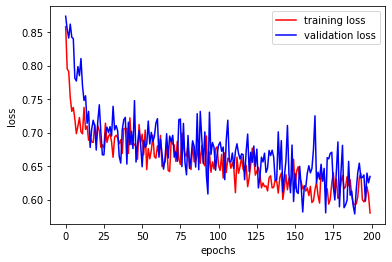

In [59]:
df = pd.read_csv(model_log_file_path, sep=",")
plt.plot(df["epoch"], df["loss"], "r", label="training loss")
plt.plot(df["epoch"], df["val_loss"], "b", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

# Model's inference function (optional)

*make_apply_unet_model* is the function to call to embeds a UNet model into a function in charge of the whole pipeline to get from an 8-bit image an 8-bit binary segmentation mask.  
Implement the *apply_unet_model* function.
Here the pipeline should include:  
* a [0,1]-normalization  
* a padding of the image (so that its dimension are 2^{unet_depth = len(unet_filters)-1} divisible)  
* the application of the UNet model  
* an unpadding of the UNet model's output (to retrieve the initial image dimensions)  
* the conversion of the UNet model's output into a binary segmentation mask by taking the label with the highest probability for each pixel  

The *pad_image* and *unpad_image* are already provided. The numpy function *np.where(condition, value if condition true, value if condition false)* should useful for an efficient conversion into a binary segmentation mask.

In [ ]:
def pad_image(image, unet_depth):
    shape = image.shape[:2]  
    if shape[0]%2**unet_depth != 0 or shape[1]%2**unet_depth != 0:
        new_shape = [shape[0] + 2**unet_depth - shape[0]%2**unet_depth, 
                     shape[1] + 2**unet_depth - shape[1]%2**unet_depth]
        new_image = np.empty([*new_shape, 3])
        new_image[0:shape[0], 0:shape[1], :] = image[...]
        
        new_image[0:shape[0],shape[1]:new_shape[1],:] = image[:,shape[1]-(new_shape[1]-shape[1]):shape[1],:]
        new_image[shape[0]:new_shape[0],0:shape[1],:] = image[shape[0]-(new_shape[0]-shape[0]):shape[0],:,:]
        new_image[shape[0]:new_shape[0],shape[1]:new_shape[1],:] = image[shape[0]-(new_shape[0]-shape[0]):shape[0],shape[1]-(new_shape[1]-shape[1]):shape[1],:]
        
        return new_image
    else:
        return image
    
def unpad_image(image, old_shape):
    im_shape = image.shape[:2]
    if im_shape[0] == old_shape[0] and im_shape[1] == old_shape[1]:
        return image
    else:
        new_image = image[0:old_shape[0], 0:old_shape[1], :]
        return new_image
    
def apply_unet_model(unet_model, unet_depth, image):
    #TO IMPLEMENT
    
    
    
    
    return segm

def make_apply_unet_model(unet_model, unet_depth):
    return lambda image: apply_unet_model(unet_model, unet_depth, image)

# Model's application on test dataset

Apply a UNet model on test dataset images.  
The model is chosen with its id and a test image with its index.  
Nothing to implement.

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model2load_id = 1

for dir in os.listdir("models"):
    if len(dir.split("modelID")) > 1:
        id = int(dir.split("_")[0].split("=")[1])
        if id == model2load_id:
            model_dir = os.path.join("models", dir)
            break

with open(os.path.join(model_dir, "model_parameters.json"), "r") as model_parameters_file:
    model_parameters = json.load(model_parameters_file)

weights_path = os.path.join(model_dir, "best_model_weights.h5")

model2 = build_unet_model(model_parameters["nb_channels_in"], 
                          model_parameters["nb_channels_out"], 
                          model_parameters["unet_filters"], 
                          model_parameters["last_activation"])

model2.load_weights(weights_path)
    
apply_model =  make_apply_unet_model(model2, len(model_parameters["unet_filters"])-1) 

test_images_dir = os.path.join(path, "test")
test_images_filenames = os.listdir(os.path.join(test_images_dir, "jpg"))

test_image_idx = 8

image = imageio.imread(os.path.join(*[test_images_dir, "jpg", test_images_filenames[test_image_idx]]))
label = imageio.imread(os.path.join(*[test_images_dir, "lbl", test_images_filenames[test_image_idx]]))

segm = apply_model(image)

plt.figure(figsize=(8,8))
plt.imshow(image)

plt.figure(figsize=(8,8))
plt.imshow(segm, cmap="gray")

plt.figure(figsize=(8,8))
plt.imshow(label, cmap="gray")